# Ebuss



This Notebook is mainly continaing two parts
* Sentiment Classification 
* Recommendataion System

Steps being performed 
* Data Sourcing
* Cleaning and EDA
* Sentiment classification model creation
* Recommendation system model creation

In [299]:
#Lets import required libraries

import pandas as pd
import numpy as np
import seaborn as sns

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag


import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn.decomposition import TruncatedSVD

# Importing metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import pairwise_distances

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

import random
import os

In [300]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [301]:
nltk.download('averaged_perceptron_tagger')
stop_words_all = stopwords.words('english')
print(stop_words_all)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\amitkumar.maheshwari\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [302]:
# We can see, stop words such as 'no', 'not' etc, can be important in  understanding the sentiment. So we should not remove them
stop_words_not_to_remove = {'no', 'nor', 'not', "don't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", "mustn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't" }
stop_words = list( set(stop_words_all) - stop_words_not_to_remove)

In [303]:
# Loading the data from CSV file
def get_parent_direcotry():
    return os.path.abspath('..')
review_df = pd.read_csv(get_parent_direcotry() + "\\Data\\sample30.csv")

### Performing EDA on Dataset

In [304]:
#Lets check the shape of the data frame
print("Shape of the Dataset", review_df.shape)

Shape of the Dataset (30000, 15)


In [305]:
#Lets check how many unique values are there in each fields
review_df.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [306]:
review_df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


In [307]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [308]:
review_df.isnull().all(axis = 0).sum()

0

In [309]:
review_df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

Here we can see that important fields such as ID, Name, Rating, Review Text are present in all the records

But, Username, and Sentiment (label) are not present in few recrods.

Sentiment lable can be ingnored while creating recommendataion system, and username can be ignored while creating sentiment classification model. But as total number of records that are missing this information are negligible, we can simple drop those records.

In [310]:
review_df = review_df[review_df['user_sentiment'].notna()]
review_df = review_df[review_df['reviews_username'].notna()]

In [311]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29936 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    29936 non-null  object
 1   brand                 29936 non-null  object
 2   categories            29936 non-null  object
 3   manufacturer          29795 non-null  object
 4   name                  29936 non-null  object
 5   reviews_date          29896 non-null  object
 6   reviews_didPurchase   15931 non-null  object
 7   reviews_doRecommend   27395 non-null  object
 8   reviews_rating        29936 non-null  int64 
 9   reviews_text          29936 non-null  object
 10  reviews_title         29747 non-null  object
 11  reviews_userCity      1900 non-null   object
 12  reviews_userProvince  166 non-null    object
 13  reviews_username      29936 non-null  object
 14  user_sentiment        29936 non-null  object
dtypes: int64(1), object(14)
memory usage

Ideally, review from those users who have bought the product is more helpful.
But we are having almost half of the records which doesn't have that information, so lets ignore that factor as of now

In [312]:
# Lets check if there may any duplicate review entries or not
review_text_count = pd.DataFrame(review_df.reviews_text.value_counts())

In [313]:
review_text_count[review_text_count.reviews_text >= 2]

,reviews_text
Great,16
Good,16
good,13
Great product,9
Excellent,6
...,...
So greeat! I also love the smell of these wipes- nice and lemony instead of the Lysol disenfectent smell This review was collected as part of a promotion.,2
This is the best product line to transition to shampooing hair less often! It helps control oil and buildup and keeps everything looks fresh. Great for revitalizing! I got this for free from influenster and I'm so glad I did! This review was collected as part of a promotion.,2
makes my kitchen smell clean and spotless. I recommended this product to all my friends and family.,2
Clorox products are awesome! Cleans fabulously and smells great! This review was collected as part of a promotion.,2


We can clearly see that there are some reviews which are being repeated.

Lets check, if we are having same review text for same product by same user. If we find such, we will remove all the duplicates

In [314]:
review_df[review_df.duplicated(subset=['reviews_text','id', 'reviews_username', 'user_sentiment'], keep=False)]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
43,AV1h6Gu0glJLPUi8IjA_,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,...",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-05-09T07:36:44.000Z,NaN,True,4,"Well, Johnson's need I say more I know, right....",2 In 1!!!,Rohnert Park,NaN,solo,Positive
44,AV1h6Gu0glJLPUi8IjA_,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,...",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-05-09T00:00:00.000Z,False,True,4,"Well, Johnson's need I say more I know, right....",2 in 1!!!,NaN,NaN,solo,Positive
67,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,NaN,True,3,Today is my first time using this product. Fel...,Why No Fragrance-Free Formula,Brooklyn,NaN,mylifeinheels,Positive
79,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T00:00:00.000Z,False,True,3,Today is my first time using this product. Fel...,Why No fragrance-free Formula,NaN,NaN,mylifeinheels,Positive
90,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-04-30T03:08:38.000Z,NaN,True,3,Today is my first time using this product. Fel...,Why No Fragrance-free Formula,Brooklyn,NaN,mylifeinheels,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29807,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2016-12-30T00:00:00.000Z,False,NaN,5,I received this product from Influenster in ex...,Smooth and silky!,NaN,NaN,joycakes,Positive
29827,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-04T00:00:00.000Z,False,True,5,This works great to make my hair shiny and hea...,Really hydrates!,NaN,NaN,emily95,Positive
29841,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2016-12-29T00:00:00.000Z,False,True,5,I received this product free from influenster ...,Good stuff,NaN,NaN,brookieboo1994,Positive
29921,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,This stuff is so hydrating and it smells so am...,Smells so freaking good!,NaN,NaN,talmariejohn,Positive


In [315]:
#lets drop duplicate records
review_df = review_df.drop_duplicates(subset = ['reviews_text','id', 'reviews_username', 'user_sentiment'],
  keep = 'last').reset_index(drop = True)

In [316]:
# Now, Lets check how many users are there who have rated multiple products
review_df.groupby(['reviews_username']).size().reset_index(name='counts')['counts'].value_counts()

1     22882
2      1572
3       236
4        85
5        51
6        33
7        12
8        10
9         7
11        7
10        5
12        4
15        3
41        2
13        2
32        1
14        1
16        1
Name: counts, dtype: int64

In [317]:
review_df.shape

(28144, 15)

In [318]:
# Lets keep a copy of this dataset which we will use later for Recommendataion system
rating_df = review_df.copy()

### Lets check the distributions of the data

<AxesSubplot:ylabel='reviews_rating'>

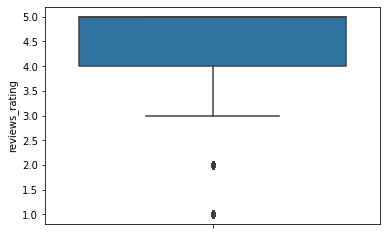

In [319]:
#Lets check the distribution of rating
sns.boxplot(y = 'reviews_rating', data = review_df)

In [320]:
review_df.reviews_rating.describe()

count    28144.000000
mean         4.521248
std          0.935835
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

There are no outliers found in Rating field

In [321]:
review_df.reviews_rating.value_counts()

5    19882
4     5576
3     1234
1     1074
2      378
Name: reviews_rating, dtype: int64

<AxesSubplot:>

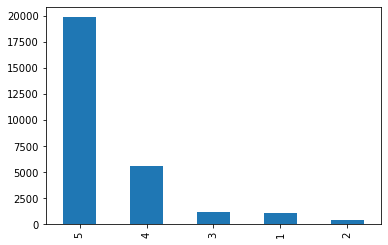

In [322]:
review_df.reviews_rating.value_counts().plot(kind = 'bar')

In [323]:
#Lets check the distribution of Sentiment label
review_df.user_sentiment.value_counts()/review_df.shape[0]

Positive    0.88939
Negative    0.11061
Name: user_sentiment, dtype: float64

<AxesSubplot:>

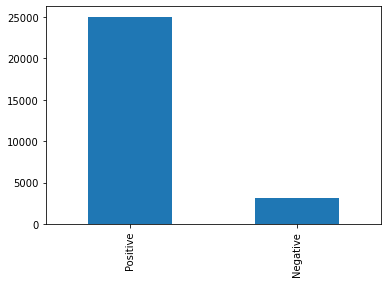

In [324]:
review_df.user_sentiment.value_counts().plot(kind = 'bar')

We can clearly see There is no outliers in rating field. So we are good to consume it as it is.

Given that classes are distributed in around 88% and 12% range respectivly.

Thus later while training the model we will have to balance these data

In [325]:
# Lets check percent wise distibution of rating in Positive reviews
positive_review_df = review_df[review_df.user_sentiment == 'Positive']
positive_review_df.reviews_rating.value_counts()/positive_review_df.shape[0]

5    0.723623
4    0.201350
3    0.041029
1    0.024130
2    0.009868
Name: reviews_rating, dtype: float64

In [326]:
# Lets check percent wise distibution of rating in Negative reviews
negative_review_df = review_df[review_df.user_sentiment == 'Negative']
negative_review_df.reviews_rating.value_counts()/negative_review_df.shape[0]

5    0.568262
4    0.172181
1    0.150980
3    0.066495
2    0.042082
Name: reviews_rating, dtype: float64

This is very counter intutive to see that Positive reviews has low rating given - such as 1 and 2 starts and also Negative Reviews have high rating given like 4 and 5 stars.

This can be due to human error in tagging the review positive or negative. 

Lets check such reviews to find any such patterns.

In [327]:
#Lets check those reviews that were marked as Negative but have 5 and 4 stars rating.
negative_5stars_review = review_df[(review_df.user_sentiment == 'Negative') & (review_df.reviews_rating >= 4)]
reviews = list(negative_5stars_review.reviews_text)
for reivew in reviews:
    print(reivew)
    print('-------')

It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.
-------
In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.
-------
This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.
-------
I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.
-------
I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.
-------
I hate to be picky, but who was responsible for the design of this product Push down on top of the package to dispense prod

-------
Clorox wipes are so convenient and thick enough to get the job done! This review was collected as part of a promotion.
-------
Love,Love the to go packs! So convienent to take with you anywhere! This review was collected as part of a promotion.
-------
I love all the Clorox products. You can never go wrong with Clorox! This review was collected as part of a promotion.
-------
I keep these under my bathroom sinks and just pull them out when needed.
-------
I use these wipes at home for everything and I keep one at work too!!!!!
-------
Clorox is great for fighting all those nasty cold germ this season! This review was collected as part of a promotion.
-------
I like the smell and the effectiveness. I use whenever I cook with meat.
-------
Convenient, especially with a baby and two teenagers in the house. This review was collected as part of a promotion.
-------
a must have with a toddler in the house. quick,easy and effectivre This review was collected as part of a promotion.
--

In [328]:
print('Total reviews with Negative label but high rating: ', len(reviews))
reviews_filtered = [review for review in reviews if not review.endswith('This review was collected as part of a promotion.')]
print(len(reviews_filtered))

Total reviews with Negative label but high rating:  2305
1607


In [329]:
#Lets check those reviews that were marked as Negative but have 5 and 4 stars rating.
positive_1stars_review = review_df[(review_df.user_sentiment == 'Positive') & (review_df.reviews_rating <= 2)]
reviews = list(positive_1stars_review.reviews_text)
for reivew in reviews:
    print(reivew)
    print('-------')

Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund
-------
Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.
-------
First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.
-------
I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.
-------
I am so disappointed! I have used this product for years because of it's soft smell and great results. The new formula feels greasy, smells awful and I don't feel like my skin looks as toned and wrinkle free anymore. This was a five sta

In [330]:
len(reviews)

851

It is quite obvious to see here, Mostly those reviews which have lower rating but marked as positive are wrongly marked. 

On other hand, Most reviews with higher rating and 'Negative' marking are either wrongly marked or are collected  as part of promotion.

We will check for the reviews that were collected as part of promotion to avoid any possiblity of biasness, and rest we will correct the marking as per the rating

In [331]:
review_df_a = review_df[review_df.reviews_text.str.endswith('This review was collected as part of a promotion.')]

In [332]:
review_df_a.reviews_rating.value_counts()

5    6054
4    1489
3     179
2      36
1      29
Name: reviews_rating, dtype: int64

In [333]:
review_df_a.user_sentiment.value_counts()

Positive    7059
Negative     728
Name: user_sentiment, dtype: int64

As expected the reivews which were collected as a part of a promotion shows high inconsistancy in terms of rating and sentiment label.

Lets drop them

In [334]:
review_df = review_df[~review_df.reviews_text.str.endswith('This review was collected as part of a promotion.')]

In [335]:
def correct_sentiment(dataframe):
    if (dataframe['reviews_rating'] >= 4) and (dataframe['user_sentiment'] == 'Negative'):
        return 'Positive'
    elif (dataframe['reviews_rating'] <= 2) and (dataframe['user_sentiment'] == 'Positive'):
        return 'Negative'
    else:
        return dataframe['user_sentiment']
    
review_df.user_sentiment = review_df.apply(correct_sentiment, axis = 1)

In [336]:
review_df.shape

(20357, 15)

# Lets Build Sentiment Classification Model using this Dataset

In [337]:
sentiment_df = review_df[['reviews_text','reviews_title', 'user_sentiment']]

In [338]:
sentiment_df

,reviews_text,reviews_title,user_sentiment
0,i love this album. it's very good. more to the...,Just Awesome,Positive
2,Good flavor.,Good,Positive
3,I read through the reviews on here before look...,Disappointed,Negative
4,My husband bought this gel for us. The gel cau...,Irritation,Negative
5,My boyfriend and I bought this to spice things...,Not worth it,Negative
...,...,...,...
27813,"Nice Conditioner. It's not greasy at all, rins...",Clay Rebalancing Conditioner,Positive
27829,I bought this last week and am already in love...,Great Conditioner,Positive
28009,I received this product for testing purposes t...,Amazing!,Positive
28012,Love it! Great product. It's very soft and was...,Love,Positive


## Text Preprocessing

* Make the text lowercase
* Remove punctuation, words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Use POS tags to get relevant words from the texts.
* Lemmatize the texts


In [339]:
# clean_text: Function clean the text and remove all the unnecessary elements.
def text_lower(text):
    text = str(text)
    text = text.lower() # Make the text lowercase
    return re.sub(' +', ' ', text) # Replace multiple spaces into one space between words

In [340]:
# Load NLP module
nlp = en_core_web_sm.load()

# Disabling few pipelines since we will not be using that using spacy
nlp.disable_pipes(['parser', 'ner', 'tok2vec'])

['parser', 'ner', 'tok2vec']

In [341]:
print(stop_words)

['we', 'been', 'these', 'can', 'own', "that'll", 'shouldn', 'again', 'does', 'its', 'an', 'of', 'wasn', "you're", 'at', 'such', 'by', 'yourselves', 'his', 's', 'them', 'isn', 'their', 'as', "mightn't", 'o', 'between', 'while', 'which', 'or', 'but', 'than', 'should', 'in', 'before', 'below', 'didn', 'wouldn', "needn't", 'doesn', 'she', 'mustn', 'y', 'other', 'you', "she's", 'aren', 'with', 'then', 'for', 'a', 'both', 'is', 've', "you'll", 'they', 'and', 'have', 'to', 'more', 'against', 'having', 're', 'himself', 'itself', 'what', 'won', 'those', 'same', 'during', 'did', 'after', 'her', 'into', 'couldn', 'me', 'when', 'on', "should've", 'herself', 'from', 'if', "you've", 'ourselves', 'hasn', 'over', 'll', 'who', 'mightn', 'i', 'ain', 'once', 'had', 'only', 'most', 'up', 'so', 'hers', 'shan', 'don', "couldn't", 'now', 'yourself', 'him', 'will', 'where', 'has', 'were', 'because', 'why', 'your', 'few', "it's", 'my', 'here', 'under', 'there', 'd', 'he', 'that', 'some', 'this', 'how', 'furthe

In [342]:
# Define a regex to clean the data.
regex_pattern = '|'.join([
    '[^\w\s]', # Remove punctuations
    '[a-zA-Z]*[0-9]+[a-zA-Z]*' # Remove alphanumeric words and words containing numbers
])

compiled_regex = re.compile(regex_pattern)

def lemmatize_and_pos(text):
    doc = nlp(text)
    clean_text = ' '.join([token.lemma_ for token in doc if (token.pos_ in ['NOUN', 'PROPN']) and (token.text not in stop_words)])
    clean_text = re.sub(compiled_regex, '', clean_text)
    return clean_text


In [343]:
sentiment_df.reviews_text = sentiment_df.reviews_text.apply(text_lower)
sentiment_df.reviews_title = sentiment_df.reviews_title.apply(text_lower)

C:\Users\amitkumar.maheshwari\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [344]:
sentiment_df.head()

,reviews_text,reviews_title,user_sentiment
0,i love this album. it's very good. more to the...,just awesome,Positive
2,good flavor.,good,Positive
3,i read through the reviews on here before look...,disappointed,Negative
4,my husband bought this gel for us. the gel cau...,irritation,Negative
5,my boyfriend and i bought this to spice things...,not worth it,Negative


In [345]:
# We are taking both Review Title and review text combined as a review
sentiment_df['review'] = sentiment_df.reviews_title + ". " + sentiment_df.reviews_text

<ipython-input-345-e841beba4563>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['review'] = sentiment_df.reviews_title + ". " + sentiment_df.reviews_text


In [346]:
sentiment_df.review = sentiment_df.review.apply(lemmatize_and_pos)

C:\Users\amitkumar.maheshwari\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [347]:
sentiment_df.review

0        awesome  love album  s good  hip hop side curr...
2                                       good  good flavor 
3        disappointed  read reviews looking buying one ...
4        irritation  husband bought gel us  gel caused ...
5        not worth  boyfriend bought spice things bedro...
                               ...                        
27813    clay rebalancing conditioner  nice conditioner...
27829    great conditioner  bought last week already lo...
28009    amazing   received product testing purposes in...
28012    love  love  great product  s soft washes well ...
28140    love  love  received review purposes influenst...
Name: review, Length: 20357, dtype: object

### Class imbalance

We can see there is a huge class imbalance, Lets handle it

We will bring the Positive - Negative ratio to as good as 50-50 

Two ways to do it
* Down Sampling
* Up Sampling

## Down Sampling

In [348]:
negative_sentiment_df_ds = sentiment_df[sentiment_df.user_sentiment == 'Negative']
positive_sentiment_df_ds = sentiment_df[sentiment_df.user_sentiment == 'Positive'].sample(n=negative_sentiment_df_ds.shape[0], random_state=1)
sentiment_df_ds = pd.concat([negative_sentiment_df_ds, positive_sentiment_df_ds])

#Lets shuffle all the rows to avoid any unwanted pattern
sentiment_df_ds = sentiment_df_ds.sample(frac=1).reset_index(drop=True)

In [349]:
sentiment_df_ds.user_sentiment.value_counts()/sentiment_df_ds.shape[0]

Negative    0.5
Positive    0.5
Name: user_sentiment, dtype: float64

### Lets use this data for Model Training



We will creating TF-IDF model on 'review' data and will use 'user_sentiment' as target variable.

In [350]:
tfidf_verctorizer = TfidfVectorizer()
tfidf = tfidf_verctorizer.fit_transform(sentiment_df_ds.review)

In [351]:
# Lets save TF-IDF model. we will need this while creating an end to end flow
save_obj(tfidf_verctorizer, "tfidf_model_ds")

In [352]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, sentiment_df_ds.user_sentiment, train_size=0.8, random_state=42)

In [353]:
y_train.value_counts()/y_train.shape[0]

Positive    0.502377
Negative    0.497623
Name: user_sentiment, dtype: float64

In [354]:
y_test.value_counts()/y_test.shape[0]

Negative    0.509494
Positive    0.490506
Name: user_sentiment, dtype: float64

In [355]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print('The f1 score:',round(f1_score(y, y_pred, average="weighted"), 2))
    print("")
    print('AUC score:', roc_auc_score(y, model.predict_proba(X)[:, 1], average='weighted'))
    print("")
    print('Confusion Matrix:')
    print(confusion_matrix(y, y_pred ))
    print("")
    print(classification_report(y, y_pred))

In [356]:
def print_model_evaluation_report(model, X_train, y_train, X_test, y_test):
    print("***Logistic Regression***")
    print("Training Performance")
    evaluate_model(model, X_train, y_train)
    print("----------------")
    print("Test Performance")
    evaluate_model(model, X_test, y_test)
    print("----------------")

### Logistic Regression Model

In [357]:
logistic_regression_ds = LogisticRegression()
logistic_regression_ds.fit(X_train, y_train)
print_model_evaluation_report(logistic_regression_ds, X_train, y_train, X_test, y_test)

***Logistic Regression***
Training Performance
The f1 score: 0.95

AUC score: 0.9862238542064337

Confusion Matrix:
[[1184   72]
 [  54 1214]]

              precision    recall  f1-score   support

    Negative       0.96      0.94      0.95      1256
    Positive       0.94      0.96      0.95      1268

    accuracy                           0.95      2524
   macro avg       0.95      0.95      0.95      2524
weighted avg       0.95      0.95      0.95      2524

----------------
Test Performance
The f1 score: 0.88

AUC score: 0.9540372670807453

Confusion Matrix:
[[277  45]
 [ 29 281]]

              precision    recall  f1-score   support

    Negative       0.91      0.86      0.88       322
    Positive       0.86      0.91      0.88       310

    accuracy                           0.88       632
   macro avg       0.88      0.88      0.88       632
weighted avg       0.88      0.88      0.88       632

----------------


### Naive Bayes Model

In [358]:
naive_bayes_ds = MultinomialNB()
naive_bayes_ds.fit(X_train, y_train)
print_model_evaluation_report(naive_bayes_ds, X_train, y_train, X_test, y_test)

***Logistic Regression***
Training Performance
The f1 score: 0.93

AUC score: 0.9768266893045872

Confusion Matrix:
[[1156  100]
 [  87 1181]]

              precision    recall  f1-score   support

    Negative       0.93      0.92      0.93      1256
    Positive       0.92      0.93      0.93      1268

    accuracy                           0.93      2524
   macro avg       0.93      0.93      0.93      2524
weighted avg       0.93      0.93      0.93      2524

----------------
Test Performance
The f1 score: 0.85

AUC score: 0.9349529152474454

Confusion Matrix:
[[276  46]
 [ 46 264]]

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86       322
    Positive       0.85      0.85      0.85       310

    accuracy                           0.85       632
   macro avg       0.85      0.85      0.85       632
weighted avg       0.85      0.85      0.85       632

----------------


### Random Forest

In [359]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [50,100,200,500],
    'min_samples_leaf': [2,5,10,20],
    'n_estimators': [10, 25, 50, 100]
}


In [360]:
grid_search = GridSearchCV(estimator=random_forest,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [361]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Wall time: 22.2 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [50, 100, 200, 500],
                         'min_samples_leaf': [2, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [362]:
grid_search.best_score_

0.8633122028526149

In [363]:
random_forest_best_ds = grid_search.best_estimator_
random_forest_best_ds

RandomForestClassifier(max_depth=200, min_samples_leaf=2, n_jobs=-1,
                       random_state=42)

In [364]:
print_model_evaluation_report(random_forest_best_ds, X_train, y_train, X_test, y_test)

***Logistic Regression***
Training Performance
The f1 score: 0.96

AUC score: 0.9934013894191163

Confusion Matrix:
[[1191   65]
 [  40 1228]]

              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96      1256
    Positive       0.95      0.97      0.96      1268

    accuracy                           0.96      2524
   macro avg       0.96      0.96      0.96      2524
weighted avg       0.96      0.96      0.96      2524

----------------
Test Performance
The f1 score: 0.89

AUC score: 0.9506010819475055

Confusion Matrix:
[[286  36]
 [ 33 277]]

              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89       322
    Positive       0.88      0.89      0.89       310

    accuracy                           0.89       632
   macro avg       0.89      0.89      0.89       632
weighted avg       0.89      0.89      0.89       632

----------------


## Up Sampling

We will creating TF-IDF model on 'review' data and will use 'user_sentiment' as target variable.

In [365]:
tfidf_verctorizer = TfidfVectorizer()
tfidf = tfidf_verctorizer.fit_transform(sentiment_df.review)

In [366]:
# Lets save TF-IDF model. we will need this while creating an end to end flow
save_obj(tfidf_verctorizer, "tfidf_model")

In [367]:
#Lets use smote to upsample the data to handle class imbalance
sm = SMOTE()
tfidf_us, y_us = sm.fit_resample(tfidf, sentiment_df.user_sentiment)

In [368]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_us, y_us, train_size=0.8, random_state=42)

In [369]:
y_train.value_counts()/y_train.shape[0]

Positive    0.500965
Negative    0.499035
Name: user_sentiment, dtype: float64

In [370]:
y_test.value_counts()/y_test.shape[0]

Negative    0.50386
Positive    0.49614
Name: user_sentiment, dtype: float64

### Logistic Regression Model

In [371]:
logistic_regression_us = LogisticRegression()
logistic_regression_us.fit(X_train, y_train)
print_model_evaluation_report(logistic_regression_us, X_train, y_train, X_test, y_test)

***Logistic Regression***
Training Performance
The f1 score: 0.97

AUC score: 0.9953060460609082

Confusion Matrix:
[[14721   273]
 [  500 14552]]

              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97     14994
    Positive       0.98      0.97      0.97     15052

    accuracy                           0.97     30046
   macro avg       0.97      0.97      0.97     30046
weighted avg       0.97      0.97      0.97     30046

----------------
Test Performance
The f1 score: 0.97

AUC score: 0.9927386960588571

Confusion Matrix:
[[3694   91]
 [ 171 3556]]

              precision    recall  f1-score   support

    Negative       0.96      0.98      0.97      3785
    Positive       0.98      0.95      0.96      3727

    accuracy                           0.97      7512
   macro avg       0.97      0.97      0.97      7512
weighted avg       0.97      0.97      0.97      7512

----------------


### Naive Bayes Model

In [372]:
naive_bayes_us = MultinomialNB()
naive_bayes_us.fit(X_train, y_train)
print_model_evaluation_report(naive_bayes_us, X_train, y_train, X_test, y_test)

***Logistic Regression***
Training Performance
The f1 score: 0.94

AUC score: 0.9842563032831168

Confusion Matrix:
[[14309   685]
 [ 1172 13880]]

              precision    recall  f1-score   support

    Negative       0.92      0.95      0.94     14994
    Positive       0.95      0.92      0.94     15052

    accuracy                           0.94     30046
   macro avg       0.94      0.94      0.94     30046
weighted avg       0.94      0.94      0.94     30046

----------------
Test Performance
The f1 score: 0.93

AUC score: 0.9814096781705425

Confusion Matrix:
[[3603  182]
 [ 315 3412]]

              precision    recall  f1-score   support

    Negative       0.92      0.95      0.94      3785
    Positive       0.95      0.92      0.93      3727

    accuracy                           0.93      7512
   macro avg       0.93      0.93      0.93      7512
weighted avg       0.93      0.93      0.93      7512

----------------


### Random Forest

In [373]:
random_forest_ds = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [50,100,200,500],
    'min_samples_leaf': [2,5,10,20],
    'n_estimators': [10, 25, 50, 100]
}


In [374]:
grid_search = GridSearchCV(estimator=random_forest_ds,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [375]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Wall time: 7min 12s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [50, 100, 200, 500],
                         'min_samples_leaf': [2, 5, 10, 20],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [376]:
grid_search.best_score_

0.9691473671416109

In [377]:
random_forest_best_us = grid_search.best_estimator_
random_forest_best_us

RandomForestClassifier(max_depth=200, min_samples_leaf=2, n_jobs=-1,
                       random_state=42)

In [378]:
print_model_evaluation_report(random_forest_best_us, X_train, y_train, X_test, y_test)

***Logistic Regression***
Training Performance
The f1 score: 0.99

AUC score: 0.9996284544467091

Confusion Matrix:
[[14836   158]
 [   70 14982]]

              precision    recall  f1-score   support

    Negative       1.00      0.99      0.99     14994
    Positive       0.99      1.00      0.99     15052

    accuracy                           0.99     30046
   macro avg       0.99      0.99      0.99     30046
weighted avg       0.99      0.99      0.99     30046

----------------
Test Performance
The f1 score: 0.97

AUC score: 0.9966892316024413

Confusion Matrix:
[[3698   87]
 [ 101 3626]]

              precision    recall  f1-score   support

    Negative       0.97      0.98      0.98      3785
    Positive       0.98      0.97      0.97      3727

    accuracy                           0.97      7512
   macro avg       0.97      0.97      0.97      7512
weighted avg       0.97      0.97      0.97      7512

----------------


We can see The best performing mode is
### Random forest
and in that too, model generated on up-sampled dataset is slightly more stable than down-sampled dataset

Thus considering this model as the best one and use this in our end to end system.

In [379]:
save_obj(random_forest_best_us, "classification_rf")

Now that we have done classification lets focus on

# Recommendation Sysytem

## User Based

As per problem statement, we will need to create a recommendation system that will recommend the products to the user

Here we will create a peer group of similar users and based on the rating given by the peer group, we will recommend the product to user.

In [380]:
# Original review_df would have much less data due to data cleaning during classification
# Lets keep a copy of rating_df in review_df so while checking the prediction, we will have proper data
review_df = rating_df.copy()
rating_df = rating_df[['reviews_username', 'reviews_rating', 'id']]

In [381]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28144 entries, 0 to 28143
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  28144 non-null  object
 1   reviews_rating    28144 non-null  int64 
 2   id                28144 non-null  object
dtypes: int64(1), object(2)
memory usage: 659.8+ KB


In [382]:
# We will need a test data for which we can evaluate the recommendation accuracy
# Also, we will need recommendation system for all the user, Train data should consist all the users
print('Total Records:',rating_df.shape[0])
print('')
print('Unique values in fields\n', rating_df.nunique())


Total Records: 28144

Unique values in fields
 reviews_username    24914
reviews_rating          5
id                    271
dtype: int64


Lets check the duplicate entries

In [383]:
rating_df[rating_df.duplicated(subset=['reviews_username', 'reviews_rating', 'id'], keep=False)]

,reviews_username,reviews_rating,id
1,dorothy w,5,AV14LG0R-jtxr-f38QfS
2,dorothy w,5,AV14LG0R-jtxr-f38QfS
10,jds1992,1,AV16khLE-jtxr-f38VFn
12,jds1992,1,AV16khLE-jtxr-f38VFn
291,cindy95,5,AV1l8zRZvKc47QAVhnAv
...,...,...,...
27522,crissyterrio,4,AVpfW8y_LJeJML437ySW
27557,rosielaughs08,4,AVpfW8y_LJeJML437ySW
27581,crissyterrio,4,AVpfW8y_LJeJML437ySW
27602,chicagojessica,4,AVpfW8y_LJeJML437ySW


In [384]:
#Lets remove these duplicate entries
rating_df = rating_df.drop_duplicates(subset = ['reviews_username', 'reviews_rating', 'id'],
  keep = 'last').reset_index(drop = True)
rating_df.shape

(27737, 3)

#### Also check if user have given multiple reviews to the same product

In [385]:
rating_df[rating_df.duplicated(subset=['reviews_username', 'id'], keep=False)]

,reviews_username,reviews_rating,id
682,laura,1,AV1YGDqsGV-KLJ3adc-O
727,suri,2,AV1YGDqsGV-KLJ3adc-O
731,laura,2,AV1YGDqsGV-KLJ3adc-O
879,suri,5,AV1YGDqsGV-KLJ3adc-O
1563,chris,4,AVpe31o71cnluZ0-YrSD
...,...,...,...
26291,dusty,5,AVpfRTh1ilAPnD_xYic2
26332,tony,5,AVpfRTh1ilAPnD_xYic2
26406,melbournesandy,5,AVpfRTh1ilAPnD_xYic2
26606,lzinzow,3,AVpftikC1cnluZ0-p31V


In [386]:
#Lets remove these duplicate entries
rating_df = rating_df.drop_duplicates(subset = ['reviews_username', 'id'],
  keep = 'last').reset_index(drop = True)
rating_df.shape

(27588, 3)

In [387]:
# We will need a test data for which we can evaluate the recommendation accuracy
# Also, we will need recommendation system for all the user, Train data should consist the users
print('Total Records:',rating_df.shape[0])
print('')
print('Unique values in fields\n', rating_df.nunique())


Total Records: 27588

Unique values in fields
 reviews_username    24914
reviews_rating          5
id                    271
dtype: int64


In [388]:
user_list = (set(rating_df[rating_df.duplicated(subset=['reviews_username'], keep=False)].reviews_username))

def is_in_user_list(user):
    return user in user_list

temp_df = rating_df[rating_df.reviews_username.apply(is_in_user_list)]
rating_test_df = temp_df.drop_duplicates(subset = ['reviews_username'], keep = 'last')
rating_test_df.head()

,reviews_username,reviews_rating,id
1095,terr,5,AV1YmDL9vKc47QAVgr7_
1215,ddstump,5,AV1YneDPglJLPUi8IJyQ
1643,morgan,5,AVpe31o71cnluZ0-YrSD
2047,warren,4,AVpe41TqilAPnD_xQH3d
2503,theoslithos,2,AVpe59io1cnluZ0-ZgDU


In [389]:
test_index = rating_test_df.index
all_index = rating_df.index

mask = ~all_index.isin(test_index)
pd.Series(mask).value_counts()

True     25738
False     1850
dtype: int64

In [390]:
rating_train_df = rating_df.loc[mask]

In [391]:
print('Train Dataframe shape', rating_train_df.shape)
print('Test Dataframe shape', rating_test_df.shape)

Train Dataframe shape (25738, 3)
Test Dataframe shape (1850, 3)


In [392]:
print('Unique values in fields in train dataset\n', rating_train_df.nunique())

Unique values in fields in train dataset
 reviews_username    24914
reviews_rating          5
id                    269
dtype: int64


In [393]:
rating_train_df = rating_train_df.reset_index(drop = True)
rating_test_df = rating_test_df.reset_index(drop = True)

In [394]:
#Lets check how many users are there who have rated multiple products
temp_grp = rating_train_df.groupby(['reviews_username']).size().reset_index(name='counts')
temp_grp[temp_grp.counts > 2]

,reviews_username,counts
15,1234,3
283,aaron,3
412,adam,3
665,alex,6
682,alexis,4
...,...,...
24054,vicki,6
24087,viewer,3
24212,wally,3
24305,wendy,5


We can see majority of the users in train dataset has given rating for only one item, while there are few users who have given rating for multiple users

In [395]:
rating_train_pivot = rating_train_df.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)


In [396]:
rating_train_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09mommy11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [397]:
dummy_rating = rating_train_df.copy()
# The products not rated by user is marked as 1 for prediction. 
dummy_rating['reviews_rating'] = dummy_rating['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

dummy_rating_pivot = dummy_rating.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [398]:
dummy_rating_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
09mommy11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Normalising the rating for each user around 0 mean

It is possible that some user would have tendency to give higher rating while other user would generally gives lower rating

Thus Normalising the rating by user's average rating would bring all the rating to same scale

#### But, as we have most users who have rated for only one product, the mean rating for them will be that one rating value only. If we will subtract that from original rating, in most entries, we will end up with '0' rating. Which will causing issues in finding user correlation matrix

In [399]:
mean_vals = np.nanmean(rating_train_pivot, axis=1)
print('Length of Mean Data:',len(mean_vals))
print('Mean Data', mean_vals)

Length of Mean Data: 24914
Mean Data [4. 1. 3. ... 5. 5. 4.]


In [400]:
rating_train_normalised = (rating_train_pivot.T-mean_vals).T

In [401]:
rating_train_normalised.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09mommy11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [402]:
rating_train_normalised['AV16khLE-jtxr-f38VFn'].value_counts()

 0.000000    20
-2.000000     3
-2.666667     1
 0.750000     1
-3.142857     1
Name: AV16khLE-jtxr-f38VFn, dtype: int64

As we can see in above example, most of the entries for rating has become 0 in normalised table.

(because, most of the users have given only one rating, and that rating is thus their mean rating. Subtracting their single rating with mean value will end up making it 0)

Thus we can't use this in getting user correlation matrix.

### Finding Cosine Similarity

In [403]:
rating_train_pivot.fillna(0)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxjki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyiah4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [404]:
user_corr_matrix = 1 - pairwise_distances(rating_train_pivot.fillna(0), metric='cosine')
user_corr_matrix[np.isnan(user_corr_matrix)] = 0


In [405]:
print(user_corr_matrix.shape)

(24914, 24914)


"user_corr_matrix" is userXuser correlation matrix.

As we have total 24914 distict users in our dataset, we got 24914 X 24914 matrix

In [406]:
print(user_corr_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


### Lets predict and evaluate the prediction

In [407]:
# We are only interested in finding similar users (Positive correlation), so lets make negative correlation to 0 to ignore them
user_corr_matrix[user_corr_matrix<0]=0


In [408]:
#Rating predicted by the user is the weighted sum of correlation with the product rating 
user_predicted_ratings = np.dot(user_corr_matrix, rating_train_pivot.fillna(0))

In [409]:
user_predicted_ratings.shape

(24914, 269)

In [410]:
# The above prediction is for all the products
# But we are looking for the predictions for only those products, which are not already rated
user_final_rating = np.multiply(user_predicted_ratings,dummy_rating_pivot)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,1.577986,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.980581,17.200280,0.0,0.0,0.0,0.0,1.392715,1.220683,...,0.0,0.0,0.000000,1.496711,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,2.886751,14.472840,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,1.636634,1.496711,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,2.886751,14.472840,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,1.636634,1.496711,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,2.886751,14.472840,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,1.636634,1.496711,0.0,0.0,0.0,0.0,0.0,0.0


In [411]:
user_final_rating['AV13O1A8GV-KLJ3akUyj'].value_counts()

0.000000    24029
2.309401      600
1.732051      225
1.632993       11
1.442671        4
1.082004        4
1.333333        3
1.503292        3
1.106003        2
1.421338        2
1.224745        2
0.997509        2
0.518476        1
1.032796        1
1.147079        1
1.980295        1
0.861727        1
0.742270        1
0.857690        1
0.481543        1
0.707107        1
1.352504        1
0.872872        1
1.203859        1
0.759326        1
0.852803        1
0.866025        1
1.571348        1
0.606478        1
1.066004        1
0.765092        1
0.968364        1
0.942809        1
2.886751        1
0.917663        1
2.264554        1
1.072113        1
1.116291        1
0.860663        1
Name: AV13O1A8GV-KLJ3akUyj, dtype: int64

#### Lets try to predict top 5 prodcuts that we should recommend to a user 

In [412]:
user = random.choice(list(user_final_rating.index))
print(user)

abby


In [413]:
# Lets see which are all the products this user hasve rated and what is rating
review_df[review_df.reviews_username == user][['reviews_rating', 'name', 'brand', 'manufacturer', 'categories' ]]

,reviews_rating,name,brand,manufacturer,categories
1383,5,"Suave Professionals Hair Conditioner, Sleek",Suave,UNILEVER,"Personal Care,Hair Care,Conditioner,Conditione..."
14396,5,Avery174 Ready Index Contemporary Table Of Con...,Avery,Avery Dennison,"Office,Office Supplies,Office Organization,Bin..."
20575,4,Chips Ahoy! Original Chocolate Chip - Cookies ...,Chips Ahoy,Nabisco Biscuit Company,"Food & Beverage,Cookies, Chips & Snacks,Cookie..."


In [414]:
d = user_final_rating.loc[user].sort_values(ascending=False)[0:5]
list(d.index)

['AVpf3VOfilAPnD_xjpun',
 'AVpe41TqilAPnD_xQH3d',
 'AV1Ymf_rglJLPUi8II2v',
 'AVpfM_ytilAPnD_xXIJb',
 'AVpfEqruilAPnD_xUWDr']

In [415]:
# Lets see which are these products
def is_product_recommended(id):
    return id in d

review_df[review_df.id.apply(is_product_recommended)][['id', 'name', 'brand', 'manufacturer', 'categories']].drop_duplicates(subset = ['id'], keep = 'last')

,id,name,brand,manufacturer,categories
1169,AV1Ymf_rglJLPUi8II2v,Cars Toon: Mater's Tall Tales,Disney,Disney/Pixar,"Movies, Music & Books,Movies,Kids' & Family,Mo..."
2519,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),FOX,Twentieth Century Fox,"Movies & TV Shows,Movies,Romance,Romantic Come..."
14225,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,Clorox,Clorox,"Household Essentials,Cleaning Supplies,Kitchen..."
17413,AVpfEqruilAPnD_xUWDr,"Newman's Own Balsamic Vinaigrette, 16.0oz",Newman's Own,"Newman's Own, Inc.","Food,Packaged Foods,Condiments, Dips, & Salad ..."
20092,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,Tostitos,Tostitos,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo..."


### Evaluating this recommendation Model on Train  dataset

In [416]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_corr_matrix)
user_correlation_df['reviews_username'] = rating_train_pivot.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24904,24905,24906,24907,24908,24909,24910,24911,24912,24913
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [417]:
dummy_train_eval = rating_train_df.copy()
dummy_train_eval['reviews_rating'] = dummy_train_eval['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_train_evalt_pivot = dummy_train_eval.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [418]:
dummy_train_evalt_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [419]:
train_predicted_ratings = np.multiply(user_predicted_ratings,dummy_train_evalt_pivot)
train_predicted_ratings

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxjki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyiah4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [420]:
from sklearn.preprocessing import MinMaxScaler
#from numpy import *

X  = train_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [421]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [422]:
total_non_nan

25738

In [423]:
rating_ = rating_train_df.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [424]:
rating_non_na = rating_.fillna(0).to_numpy()

In [425]:
y_non_na = np.nan_to_num(y)

In [426]:
rmse = (sum(sum((rating_non_na - y_non_na )**2))/total_non_nan)**0.5
print('RMSE value for Training dataset:', rmse)

RMSE value for Training dataset: 1.4782353056262707


### Evaluating this recommendation Model on Test  dataset

In [427]:
rating_test_df

,reviews_username,reviews_rating,id
0,terr,5,AV1YmDL9vKc47QAVgr7_
1,ddstump,5,AV1YneDPglJLPUi8IJyQ
2,morgan,5,AVpe31o71cnluZ0-YrSD
3,warren,4,AVpe41TqilAPnD_xQH3d
4,theoslithos,2,AVpe59io1cnluZ0-ZgDU
...,...,...,...
1845,cass,4,AVpfW8y_LJeJML437ySW
1846,joseph,5,AVpfW8y_LJeJML437ySW
1847,poisonivy,5,AVpfW8y_LJeJML437ySW
1848,ravy,5,AVpfW8y_LJeJML437ySW


In [428]:
rating_test_pivot = rating_test_df.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
rating_test_pivot

id,AV1YmDL9vKc47QAVgr7_,AV1YneDPglJLPUi8IJyQ,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zippy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [429]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_corr_matrix)
user_correlation_df['reviews_username'] = rating_train_pivot.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24904,24905,24906,24907,24908,24909,24910,24911,24912,24913
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [430]:
# Now, lets pick correlation for only those users which are present in test data frame

user_list = list(rating_test_df.reviews_username)
user_correlation_df.columns = rating_train_pivot.index.tolist()

In [431]:
print('Total users in test dataframe', len(set(user_list)))

Total users in test dataframe 1850


In [432]:
# Filtering the user correlation dataframe with test users
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(user_list)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(user_list)]
user_correlation_df_3 = user_correlation_df_2.T

In [433]:
print('Shape of filtered user correlation dataframe:', user_correlation_df_3.shape)

Shape of filtered user correlation dataframe: (1850, 1850)


In [434]:
test_predicted_ratings = np.dot(user_correlation_df_3, rating_test_pivot.fillna(0))
test_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 4.77047061, 1.37504775,
        0.        ],
       [0.        , 0.        , 0.        , ..., 8.00487161, 0.91064762,
        1.87317162],
       [0.        , 0.        , 0.        , ..., 4.77047061, 1.37504775,
        0.        ],
       ...,
       [0.        , 0.        , 1.39262125, ..., 2.48746534, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 4.77047061, 1.37504775,
        0.        ],
       [0.        , 0.        , 0.        , ..., 5.        , 0.        ,
        3.53553391]])

In [435]:
dummy_test = rating_test_df.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test_pivot = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [436]:
dummy_test_pivot.shape

(1850, 100)

Please note, the shape turned out to be 1882X103 because, in out test dataset we have data associated to only 103 distinct items

In [437]:
test_predicted_ratings = np.multiply(test_predicted_ratings,dummy_test_pivot)
test_predicted_ratings

id,AV1YmDL9vKc47QAVgr7_,AV1YneDPglJLPUi8IJyQ,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zipper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zippy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Lets calculate Root Mean Squared Error 

In [438]:
from sklearn.preprocessing import MinMaxScaler
#from numpy import *

X  = test_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [439]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [440]:
rating_ = rating_test_df.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [441]:
rating_non_na = rating_.fillna(0).to_numpy()

In [442]:
y_non_na = np.nan_to_num(y)

In [443]:
rmse = (sum(sum((rating_non_na - y_non_na )**2))/total_non_nan)**0.5
print(rmse)

1.885707953938378


In [444]:
# Lets compare this RMSE value from predicated rating with the RMSE value from random guess
random_y = c = np.zeros([rating_non_na.shape[0], rating_non_na.shape[1]])

In [445]:
for row in range (0, rating_non_na.shape[0]):
    for col in range (0, rating_non_na.shape[1]):
        if rating_non_na[row][col] > 0:
            random_y[row][col] = random.randint(1, 5)

In [446]:
random_rmse = (sum(sum((rating_non_na - random_y )**2))/total_non_nan)**0.5
print(random_rmse)

2.2746547109515447


## Item Based Recommendation System

Now, lets check Item based similarity and make recommendation system on it

In [447]:
rating_train_df, rating_test_df = train_test_split(rating_df, test_size=0.2, random_state=32)

print(rating_train_df.shape)
print(rating_test_df.shape)

(22070, 3)
(5518, 3)


In [448]:
print('Unique values in fields in parent dataset\n', rating_df.nunique())
print('Unique values in fields in train dataset\n', rating_train_df.nunique())

Unique values in fields in parent dataset
 reviews_username    24914
reviews_rating          5
id                    271
dtype: int64
Unique values in fields in train dataset
 reviews_username    20217
reviews_rating          5
id                    264
dtype: int64


As we can see the train data we dont have all the items present.
We will need to pull out missing items from test data to train data

In [449]:
all_items = set(rating_df.id)
train_items = set(rating_train_df.id)
remaining_items = all_items - train_items
remaining_items

{'AV14LG0R-jtxr-f38QfS',
 'AV1Yo6FPglJLPUi8IK3u',
 'AVpe-MCY1cnluZ0-bCv_',
 'AVpe4hE0ilAPnD_xQABx',
 'AVpe5tC61cnluZ0-ZZ86',
 'AVpfDbSP1cnluZ0-c3wo',
 'AVpfa1joLJeJML4385hb'}

In [450]:
# Lets pull this items from test data to train data
temp_df = rating_test_df[rating_test_df.id.isin(remaining_items)]
temp_df.shape
rating_train_df = pd.concat([rating_train_df, temp_df])
rating_test_df = rating_test_df[~rating_test_df.id.isin(remaining_items)]

In [451]:
print(rating_train_df.shape)
print(rating_test_df.shape)

(22077, 3)
(5511, 3)


In [452]:
dummy_train = rating_train_df.copy()
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)


In [453]:
rating_train_pivot = rating_train_df.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [454]:
rating_train_pivot.shape

(271, 20224)

In [455]:
rating_train_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zt313,zubb,zuttle,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [456]:
dummy_train.head(3)

,reviews_username,reviews_rating,id
9015,angelxheart,0,AVpf3VOfilAPnD_xjpun
17521,carebear44,0,AVpfJP1C1cnluZ0-e3Xy
6314,xcoupon,0,AVpf3VOfilAPnD_xjpun


In [457]:
dummy_train_pivot = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [458]:
dummy_train_pivot.shape

(20224, 271)

Lets normalise the rataing

In [459]:
mean_val = np.nanmean(rating_train_pivot, axis=1)
rating_train_normalised_pivot = (rating_train_pivot.T-mean_val).T

In [460]:
rating_train_normalised_pivot.head(3)

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zt313,zubb,zuttle,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets check, normalised vs non normalised values

In [461]:
print('Non Normalised values counts of rating for item: AV13O1A8GV-KLJ3akUyj')
print(rating_train_pivot.loc['AV13O1A8GV-KLJ3akUyj'].value_counts())
print('Normalised values counts of rating for item: AV13O1A8GV-KLJ3akUyj')
print(rating_train_normalised_pivot.loc['AV13O1A8GV-KLJ3akUyj'].value_counts())
print("")
print('Non Normalised values counts of rating for item: AV14LG0R-jtxr-f38QfS')
print(rating_train_pivot.loc['AV14LG0R-jtxr-f38QfS'].value_counts())
print('Normalised values counts of rating for item: AV14LG0R-jtxr-f38QfS')
print(rating_train_normalised_pivot.loc['AV14LG0R-jtxr-f38QfS'].value_counts())

Non Normalised values counts of rating for item: AV13O1A8GV-KLJ3akUyj
5.0    1
Name: AV13O1A8GV-KLJ3akUyj, dtype: int64
Normalised values counts of rating for item: AV13O1A8GV-KLJ3akUyj
0.0    1
Name: AV13O1A8GV-KLJ3akUyj, dtype: int64

Non Normalised values counts of rating for item: AV14LG0R-jtxr-f38QfS
5.0    1
Name: AV14LG0R-jtxr-f38QfS, dtype: int64
Normalised values counts of rating for item: AV14LG0R-jtxr-f38QfS
0.0    1
Name: AV14LG0R-jtxr-f38QfS, dtype: int64


Here too we can see, due to less rating (i.e. only one rating) for any product,  average rating of the product becomes that single rating value only.
And normalising the rating makes it 0

Lets calculate cosine similarity

In [462]:
item_corr_matrix = 1 - pairwise_distances(rating_train_pivot.fillna(0), metric='cosine')
item_corr_matrix[np.isnan(item_corr_matrix)] = 0
print(item_corr_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


As we are interested in only similar products, lets make all negative correlation to 0 so we can ignore them later

In [463]:
item_corr_matrix[item_corr_matrix<0]=0

### Lets make prediction

In [464]:
item_predicted_ratings = np.dot((rating_train_pivot.fillna(0).T),item_corr_matrix)
item_predicted_ratings.shape

(20224, 271)

In [465]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train_pivot)
item_final_rating.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.015224,0.046734,0.0,0.0,0.0,0.003798,0.0,0.006654,...,0.050368,0.000000,0.0,0.0,0.0,0.077538,0.018527,0.0,0.146582,0.009605
01impala,0.0,0.0,0.017194,0.046749,0.0,0.0,0.0,0.000000,0.0,0.010019,...,0.000000,0.015196,0.0,0.0,0.0,0.000000,0.009489,0.0,0.000000,0.000000


In [466]:
user = random.choice(list(item_final_rating.index))
print(user)

tanksgv14


In [467]:
d = item_final_rating.loc[user].sort_values(ascending=False)[0:5]
d.index

Index(['AVpfRTh1ilAPnD_xYic2', 'AVpe41TqilAPnD_xQH3d', 'AVpf0eb2LJeJML43EVSt',
       'AVpf2tw1ilAPnD_xjflC', 'AVpe59io1cnluZ0-ZgDU'],
      dtype='object', name='id')

In [468]:
# Lets see which are all the products this user hasve rated and what is rating
review_df[review_df.reviews_username == user][['reviews_rating', 'name', 'brand', 'manufacturer', 'categories' ]]

,reviews_rating,name,brand,manufacturer,categories
24677,5,Godzilla 3d Includes Digital Copy Ultraviolet ...,Warner Home Video,Test,"Movies, Music & Books,Movies,Action & Adventur..."


In [469]:
# Lets see which are these products
def is_product_recommended(id):
    return id in d

review_df[review_df.id.apply(is_product_recommended)][['id', 'name', 'brand', 'manufacturer', 'categories']].drop_duplicates(subset = ['id'], keep = 'last')

,id,name,brand,manufacturer,categories
2519,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),FOX,Twentieth Century Fox,"Movies & TV Shows,Movies,Romance,Romantic Come..."
3217,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,Universal Home Video,Universal,"Movies, Music & Books,Movies,Comedy,Movies & T..."
5300,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),Sony Pictures,SONY CORP,"Movies, Music & Books,Ways To Shop Entertainme..."
6186,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),Summit Entertainment,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh..."
26904,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,Disney,Walt Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa..."


### Evaluating model on train dataset

In [470]:
# Convert the item_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_corr_matrix)
item_correlation_df['id'] = rating_train_pivot.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005694,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [471]:
dummy_train_eval = rating_train_df.copy()
dummy_train_eval['reviews_rating'] = dummy_train_eval['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_train_evalt_pivot = dummy_train_eval.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [472]:
train_predicted_ratings = np.multiply(item_predicted_ratings,dummy_train_evalt_pivot)

In [473]:
X  = train_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

MinMaxScaler(feature_range=(1, 5))


In [474]:
total_non_nan = np.count_nonzero(~np.isnan(y))
rating_ = rating_train_df.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
rating_non_na = rating_.fillna(0).to_numpy()
y_non_na = np.nan_to_num(y)

In [475]:
rmse = (sum(sum((rating_non_na - y_non_na )**2))/total_non_nan)**0.5
print('RMSE value for Training dataset:', rmse)

RMSE value for Training dataset: 0.7820147914846123


### Lets evaluate the model on test dataset

In [476]:
print(rating_test_df.shape)
common_test_df = rating_test_df[rating_test_df.id.isin(rating_train_df.id)]
print(common_test_df.shape)

(5511, 3)
(5511, 3)


In [477]:
rating_test_pivot = common_test_df.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
rating_test_pivot.head(5)

reviews_username,08dallas,1234,123soccermom,12gage,17roses,1943,1disappoint,1olaygal,1shop,1stcavdivision,...,zeeleader,zeramm,zeroonec,ziana,ziggy,znxfyt,zookeeper,zout22389,zulaa118,zwithanx
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [478]:
rating_test_pivot.shape

(180, 5381)

In [479]:
# Convert the item_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_corr_matrix)
item_correlation_df['id'] = rating_train_pivot.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005694,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [480]:
item_list = set(list(common_test_df.id))
item_correlation_df.columns = rating_train_pivot.index.tolist()
item_correlation_df.head()

,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005694,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [481]:
print('Total products in item correlation matrix dataframe', len(set(item_correlation_df.index)))

Total products in item correlation matrix dataframe 271


In [482]:
item_correlation_df.shape

(271, 271)

In [483]:
print('Total products in test dataframe', len(item_list))

Total products in test dataframe 180


In [484]:
set_1 = set(item_correlation_df.index)
set_2 = set(item_list)
set_3 = set_1 - set_2
set_4 = set_2 - set_1
print(len(set_3))
print(len(set_4))

91
0


In [485]:
# Filtering the item correlation dataframe with test users
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(item_list)]
print('Shape of item_correlation_df_1:', item_correlation_df_1.shape)
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(item_list)]
print('Shape of item_correlation_df_2:', item_correlation_df_2.shape)
item_correlation_df_3 = item_correlation_df_2.T
print('Shape of item_correlation_df_3:', item_correlation_df_3.shape)

Shape of item_correlation_df_1: (180, 271)
Shape of item_correlation_df_2: (180, 180)
Shape of item_correlation_df_3: (180, 180)


In [486]:
print('Shape of filtered user correlation dataframe:', item_correlation_df_3.shape)

Shape of filtered user correlation dataframe: (180, 180)


In [487]:
item_correlation_df_3[item_correlation_df_3<0]=0

item_predicted_ratings = np.dot(rating_test_pivot.fillna(0).T, item_correlation_df_3)
item_predicted_ratings

array([[0.        , 0.01455038, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02292558, 0.06233253, 0.        , ..., 0.01265229, 0.        ,
        0.        ],
       [0.        , 0.01365336, 0.        , ..., 0.        , 0.        ,
        0.01324899],
       ...,
       [0.        , 0.0227556 , 0.        , ..., 0.        , 0.        ,
        0.02208165],
       [0.        , 0.05663794, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0227556 , 0.        , ..., 0.        , 0.        ,
        0.02208165]])

In [488]:
dummy_test = common_test_df.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
item_predicted_ratings = np.multiply(item_predicted_ratings,dummy_test)

In [489]:
X  = item_predicted_ratings.copy() 
X = X[X>0]
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

MinMaxScaler(feature_range=(1, 5))


In [490]:
y.shape

(5381, 180)

In [491]:
total_non_nan = np.count_nonzero(~np.isnan(y))
rating_ = common_test_df.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
rating_non_na = rating_.fillna(0).to_numpy()
y_non_na = np.nan_to_num(y)
rmse = (sum(sum((rating_non_na - y_non_na )**2))/total_non_nan)**0.5
print(rmse)

0.8339135033713734


### We can clearly see that Item based recommendation model is performing better in predicting the rating (i.e. predicting that how more or less user will like the product)

In [492]:
# Lets save this model as pickle file
save_obj(item_corr_matrix,  'recommendation')